<a href="https://colab.research.google.com/github/kryvokhyzha/Neural-Network-and-CV/blob/master/Modified_Seminar5_(MNIST_CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://engmrk.com/wp-content/uploads/2018/09/LeNet_Original_Image.jpg)

![alt text](https://engmrk.com/wp-content/uploads/2018/09/LeNEt_Summary_Table.jpg)

In [0]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [0]:
import torchvision.datasets

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)


  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 20645828.06it/s]                            


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 300733.80it/s]                           
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5258842.11it/s]                           
8192it [00:00, 131411.88it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [4]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:
len(y_train), len(y_test)

(60000, 10000)

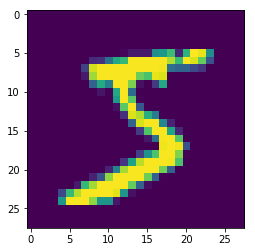

tensor(5)


In [6]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [0]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [8]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [0]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.layer1 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2),
                                          torch.nn.ReLU(), torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=0),
                                          torch.nn.ReLU(), torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc1   = torch.nn.Linear(5 * 5 * 64, 1024)
        self.act1  = torch.nn.ReLU()
        
        self.fc2   = torch.nn.Linear(1024, 512)
        self.act2  = torch.nn.ReLU()
        
        self.fc3   = torch.nn.Linear(512, 128)
        self.act3  = torch.nn.ReLU()
        
        self.fc4   = torch.nn.Linear(128, 32)
        self.act4  = torch.nn.ReLU()
        
        self.fc5   = torch.nn.Linear(32, 10)
    
    def forward(self, x):
        
        out = self.layer1(x)
        
        out = self.layer2(out)
        
        out = out.view(out.size(0), out.size(1) * out.size(2) * out.size(3))

        out = self.fc1(out)
        out = self.act1(out)
        
        out = self.fc2(out)
        out = self.act2(out)
        
        out = self.fc3(out)
        out = self.act3(out)
        
        out = self.fc4(out)
        out = self.act4(out)
        
        out = self.fc5(out)
        
        return out
    
lenet5 = LeNet5()

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [0]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=3.0e-4, betas=(0.9, 0.999))

In [0]:
from tqdm import tqdm
from IPython import display
import numpy as np
from sklearn.metrics import accuracy_score

In [0]:
def show_plots(train_accuracy_history, train_loss_history, test_accuracy_history, test_loss_history):
  _, axes = plt.subplots(1, 2, figsize=(16, 6))

  axes[0].set_title("losses")
  axes[0].plot(train_loss_history, label="train loss")
  axes[0].plot(test_loss_history, label="val loss")
  axes[0].legend()

  axes[1].set_title("accuracies")
  axes[1].plot(train_accuracy_history, label="train accuracy")
  axes[1].plot(test_accuracy_history, label="val accuracy")
  axes[1].legend()

  plt.show() 


In [34]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

train_accuracy_history = []
train_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in tqdm(range(10000)):
    display.clear_output(wait=True)
    
    # 1. forward
    lenet5.train(True)
    loss_batch = []
    acc_batch = []
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        # 1.1 получаем батчи
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        # 1.2 получаем предсказания сети
        preds = lenet5.forward(X_batch) 
        
        # 1.3 вычисляем accuracy на данном батче по предсказаниями и правильным ответам
        acc_batch.append(accuracy_score(np.argmax(preds.data.cpu().numpy(), axis=1), y_batch.data.cpu().numpy()))
        
        # 1.4 вычисляем loss (кросс-эетропию)
        loss_train = loss(preds, y_batch)
        
        # 1.5 backward
        loss_train.backward()
        
        # 1.6 обновляем веса
        optimizer.step()
        
        # 1.7 зануляем градиент
        optimizer.zero_grad()
        
        # 1.8 запоминаем ошибку на трейне
        loss_batch.append(loss_train.data.cpu().numpy())
        
    train_loss_history.append(np.mean(loss_batch))
    train_accuracy_history.append(np.mean(acc_batch))
    
    # 2. Validation
    lenet5.train(False)
    loss_batch = []
    acc_batch = []
    order = np.random.permutation(len(X_test))
    for start_index in range(0, len(X_test), batch_size):
        # 2.1 получаем батчи
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_test[batch_indexes].to(device)
        y_batch = y_test[batch_indexes].to(device)
        
        # 2.2 получаем предсказания сети
        preds = lenet5.forward(X_batch) 
        
        # 2.3 вычисляем accuracy на данном батче по предсказаниями и правильным ответам
        acc_batch.append(accuracy_score(np.argmax(preds.data.cpu().numpy(), axis=1), y_batch.data.cpu().numpy()))
        
        # 2.4 вычисляем loss (кросс-эетропию)
        loss_test = loss(preds, y_batch)
        
        # 2.5 запоминаем ошибку на тесте
        loss_batch.append(loss_test.data.cpu().numpy())

    test_loss_history.append(np.mean(loss_batch))
    test_accuracy_history.append(np.mean(acc_batch))
#     test_preds = lenet5.forward(X_test)
#     test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
#     accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
#     test_accuracy_history.append(accuracy)
    
    # 3. Save model
    if len(test_loss_history) > 1 and test_loss_history[-1] < np.min(test_loss_history[:-1]):
      torch.save(lenet5.state_dict(), 'model.pt')
      
      
    # 4. Show plots
    show_plots(train_accuracy_history=train_accuracy_history,
               train_loss_history=train_loss_history,
               test_accuracy_history=test_accuracy_history,
               test_loss_history=test_loss_history)
    
    print()
    print("Final loss: ", test_loss_history[-1])
    print("Final accuracy: ", test_accuracy_history[-1])
    
    !nvidia-smi

KeyboardInterrupt: ignored

In [35]:
!nvidia-smi

print()

test_preds = lenet5.forward(X_test)
print("Final loss: ", loss(test_preds, y_test).data.cpu())
    
accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
print("Final accuracy: ", accuracy)

Sun Jun 30 23:02:14 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    30W /  70W |   1687MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  